# Cross-Assay Integrative Analyses

In [41]:
import polars as pl
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from venn import venn
from yogiroc import *
sys.path.append("../../2_individual_assay_analyses")
from utils import *
%matplotlib inline

## 1. Loading allele information

### 1.1 VarChAMP Dataset Alleles Merged with Pillar Project

In [9]:
varchamp_pillar_df = pl.read_csv("../../1_allele_collection/3_outputs/varchamp_alleles_with_pillar_annotations.tsv", 
                                 separator="\t", infer_schema_length=1000000)
print("VarChAMP dataset shape:", varchamp_pillar_df.shape)
# varchamp_pillar_df.filter(pl.col("pillar_tested")).unique("symbol")

VarChAMP dataset shape: (9055, 587)


In [10]:
print("Overlapped unique gene variants between VarChAMP COLLECTION (including not tested) and Pillar Project:")
varchamp_pillar_df.filter(pl.col("pillar_tested")).unique("gene_variant").shape[0]

Overlapped unique gene variants between VarChAMP COLLECTION (including not tested) and Pillar Project:


268

In [11]:
pillar_clinvar_df = pl.read_csv(
    "../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
    pl.lit(True).alias("pillar_tested")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes Pillar ALL:", pillar_clinvar_df.unique(subset="Gene").shape[0])
print("Number of unique genes Pillar SNP:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Filtered missense/SNP pillar dataset shape: (121504, 104)
Number of unique genes Pillar ALL: 41
Number of unique genes Pillar SNP: 33
Number of unique gene variants: 61091


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,aa_change,pillar_tested
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,bool
27534,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
8857,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
27540,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Gly""","""Ala148Gly""",true
8863,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thyge

In [12]:
pillar_varchamp_df = pl.read_csv(
    "../../1_allele_collection/3_outputs/pillar_alleles_with_varchamp_annotations.tsv", 
    # schema_overrides={
    #     "Chrom": pl.String, 
    #     'aa_pos': pl.String, 
    #     'auth_reported_score': pl.String
    # },
    separator="\t",
    infer_schema_length=10000000
)
# pillar_varchamp_df.shape

### 1.2 Imaging Data

In [13]:
def plot_gene_level_summary(total_allele_hit_sum_df, assay):
    # Convert to pandas and sort
    total_allele_hit_sum_df = total_allele_hit_sum_df.to_pandas().sort_values(
        by=["total_counts"], ascending=False
    ).reset_index(drop=True)
    n_genes = len(total_allele_hit_sum_df)
    # Dynamically scale figure size
    fig_height = max(6, min(n_genes * 0.3, 40))
    fig_width = 6  # Slightly wider to accommodate labels
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # Create the barplots
    # Total counts (background bars)
    sns.barplot(
        data=total_allele_hit_sum_df, 
        y="symbol", 
        x="total_counts", 
        hue="clinvar_clnsig_clean", 
        palette=palette_dict["clinvar_clnsig_clean"],
        alpha=0.6,  # Make background bars slightly transparent
        ax=ax,
        gap=.1
    )
    # Hit counts (foreground bars)
    sns.barplot(
        data=total_allele_hit_sum_df, 
        y="symbol", 
        x="hit_counts", 
        hue="clinvar_clnsig_clean", 
        palette=["orange","forestgreen"],
        ax=ax,
        gap=.1
    )
    
    # Add percentage labels
    # Get unique categories and their positions
    categories = total_allele_hit_sum_df["clinvar_clnsig_clean"].unique()
    n_categories = len(categories)
    
    # Calculate bar positions for each category
    bar_height = 0.5 / n_categories  # Default seaborn bar height divided by number of categories
    
    for i, gene in enumerate(total_allele_hit_sum_df["symbol"].unique()):
        gene_data = total_allele_hit_sum_df[total_allele_hit_sum_df["symbol"] == gene]
        for j, category in enumerate(categories):
            cat_data = gene_data[gene_data["clinvar_clnsig_clean"] == category]
            if not cat_data.empty:
                # Calculate bar position
                bar_center = i + (j - (n_categories - 1) / 2) * bar_height
                # print(bar_center)
                # Get the hit percentage value
                hit_perc = cat_data["hit_perc"].iloc[0]
                hit_counts = cat_data["hit_counts"].iloc[0]
                # Add percentage label at the end of the hit_counts bar
                ax.text(
                    hit_counts + max(total_allele_hit_sum_df["hit_counts"]) * 0.01,  # Small offset
                    bar_center,
                    f"{hit_perc:.1f}%",
                    ha="left",
                    va="center",
                    fontsize=9 if n_genes > 20 else 10,
                    fontweight="bold"
                )
    
    # Formatting
    ax.grid(alpha=0.2, axis='x')
    ax.set_xlabel("Count", fontsize=11)
    ax.set_ylabel("Gene Symbol", fontsize=11)
    ax.set_title(f"Gene-Level Variant Summary with Hit Percentages {assay}", fontsize=13)
    
    # Adjust x-axis limit to accommodate labels
    max_count = max(total_allele_hit_sum_df["total_counts"].max(), 
                    total_allele_hit_sum_df["hit_counts"].max())
    ax.set_xlim(0, max_count * 1.15)
    
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    # Remove duplicate legend entries (seaborn creates duplicates with multiple barplots)
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    
    ax.legend(unique_handles, unique_labels, 
              title="ClinVar Significance", 
              fontsize=10, 
              loc="lower right",
              framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
    
    return total_allele_hit_sum_df

In [56]:
IMG_FEAT_SET = ["GFP", "Morph", "DNA", "Mito", "AGP"]
img_metric_df = pl.DataFrame()
img_metric_df = pl.read_csv("../1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
img_metric_df = img_metric_df.with_columns(
    pl.col("gene_allele").alias("gene_variant"),
    pl.col("gene_allele").str.split("_").list.get(0).alias("Gene"),
    pl.lit(True).alias("image_assayed"),
    (pl.col(f"Altered_95th_perc_GFP")==1).alias("img_prot_hits_5perc"),
    pl.any_horizontal([f"Altered_95th_perc_{feat}" for feat in IMG_FEAT_SET]).alias("img_hits_5perc"),
    pl.any_horizontal([f"Altered_99th_perc_{feat}" for feat in IMG_FEAT_SET]).alias("img_hits_1perc"),
    pl.col("clinvar_clnsig_clean").fill_null("6_No_ClinVar").alias("clinvar_clnsig_clean")
).unique("gene_variant")
print("VarChAMP Imaging assay unique variants:", img_metric_df.shape[0])

VarChAMP Imaging assay unique variants: 312


In [57]:
img_metric_df.filter((pl.col("img_hits_5perc"))&(pl.col("clinvar_clnsig_clean")=="2_Benign")&(pl.col("Gene")!="BRCA1"))#["Interval 1 MaveDB class"]

gene_allele,cc_t_stat,cc_p_val,abun_t_stat,abun_p_val,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,Gene,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,…,gnomAD4.1_joint_flag,Aloft_Fraction_transcripts_affected,gnomAD2.1.1_exomes_non_neuro_SAS_AF,BayesDel_noAF_score,PHACTboost_score,MutationAssessor_rankscore,MetaSVM_pred,ALFA_East_Asian_AN,gnomAD2.1.1_exomes_non_neuro_ASJ_AN,gnomAD2.1.1_exomes_non_cancer_ASJ_AN,MetaSVM_score,MetaLR_rankscore,HGVSp_VEP,ALFA_Other_Asian_AC,gnomAD4.1_joint_AMI_nhomalt,ESM1b_score,MetaRNN_score,gnomAD4.1_joint_AFR_AC,PHACTboost_rankscore,VariationID,ESM1b_pred,gnomAD2.1.1_exomes_non_neuro_AMR_AN,GeneSymbol,gnomAD2.1.1_exomes_controls_AMR_AF,BayesDel_noAF_pred,REVEL_score,gnomAD2.1.1_exomes_non_cancer_FIN_AN,MutPred_AAchange,SIFT_pred,GERP_91_mammals_rankscore,phyloP17way_primate_rankscore,AltaiNeandertal,APPRIS,image_assayed,img_prot_hits_5perc,img_hits_5perc,img_hits_1perc
str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,…,str,str,str,f64,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,bool,bool,bool,bool
"""RAD51D_Glu233Gly""",2.015139,0.083729,-22.260535,9.3341e-8,"""2025_01_Batch_13-14""",0.652318,0.873758,0.961744,0.906685,0.712353,0.696708,0.896748,0.966901,0.931522,0.699196,0.674513,0.885253,0.964322,0.919104,0.705775,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""RAD51D""","""RAD51D""","""ENSG00000185379""",7201,12776,"""CCSBVarC001140""",…,""".""",""".""","""3.146760e-03""",-0.07823,"""0.0150280587944397""","""0.48914""","""T""","""4530""","""6048""","""9428""",-0.5609,0.61193,"""p.Glu233Gly""","""1""","""0""","""-7.244""","""0.012577295""","""234""","""0.27128""",138873,"""T""","""29852""","""RAD51D""","""8.293560e-03""","""T""","""0.189""","""21078""",""".""",""".""",""".""",0.47831,"""T/T""","""principal1""",true,true,true,false


### 1.2.1 Get the protein mislocalization hits

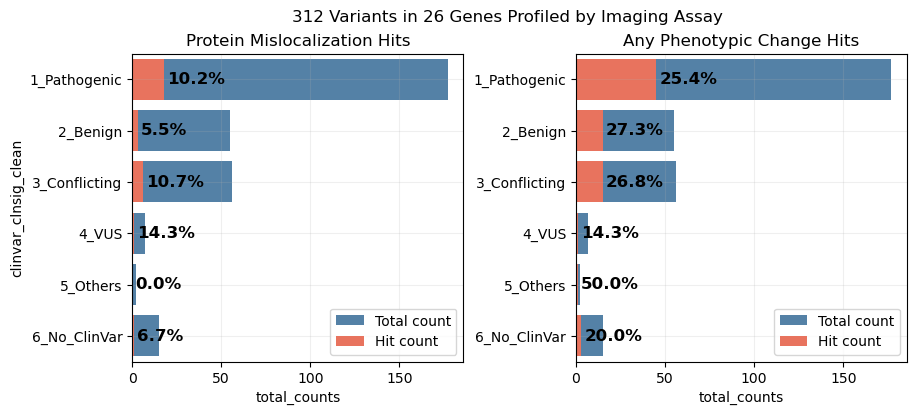

In [60]:
img_clinvar_clean_all = img_metric_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS","5_Others","6_No_ClinVar"]) #pl.col("Gene")!="BRCA1" #
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_clinvar_clean_hits_prot = img_metric_df.unique("gene_variant").filter(
    (pl.col("img_prot_hits_5perc")) #& (pl.col("Gene")!="BRCA1") #& (pl.col("clinvar_clnsig_clean")#.is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"]))
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_hits_prot = img_clinvar_clean_all.join(
    img_clinvar_clean_hits_prot,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
img_hits_prot.sort("clinvar_clnsig_clean")

fig, axes = plt.subplots(1,2,figsize=(10,4))
plot_df = img_hits_prot.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",
            x="total_counts", color="steelblue",
            label="Total count", ax=axes[0])
sns.barplot(plot_df, y="clinvar_clnsig_clean",
                 x="hit_counts", color="tomato",
                 label="Hit count", ax=axes[0])
axes[0].set_title(f"Protein Mislocalization Hits")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[0].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
axes[0].grid(alpha=.2)

img_clinvar_clean_hits_all = img_metric_df.unique("gene_variant").filter(
    (pl.col("img_hits_5perc")) #& (pl.col("Gene")!="BRCA1")  ## (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & 
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_hits_all = img_clinvar_clean_all.join(
    img_clinvar_clean_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
plot_df = img_hits_all.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",
            x="total_counts", color="steelblue",
            label="Total count", ax=axes[1])
sns.barplot(plot_df, y="clinvar_clnsig_clean",
                 x="hit_counts", color="tomato",
                 label="Hit count", ax=axes[1])
axes[1].set_title(f"Any Phenotypic Change Hits")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[1].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
axes[1].grid(alpha=.2)
axes[1].set_ylabel("")
plt.suptitle(f"{img_metric_df.shape[0]} Variants in {img_metric_df.unique('Gene').shape[0]} Genes Profiled by Imaging Assay", y=.99)
plt.subplots_adjust(wspace=.34)

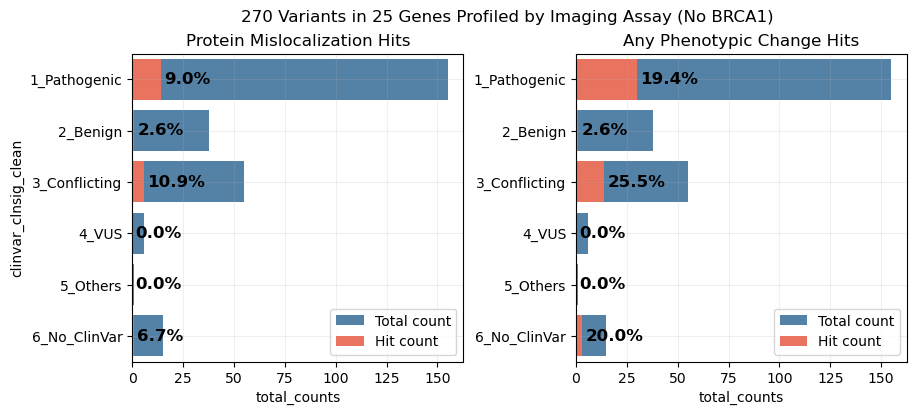

In [74]:
img_clinvar_clean_all = img_metric_df.unique("gene_variant").filter(
    pl.col("Gene")!="BRCA1" #pl.col("clinvar_clnsig_clean")#.is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_clinvar_clean_hits_prot = img_metric_df.unique("gene_variant").filter(
    (pl.col("img_prot_hits_5perc")) & (pl.col("Gene")!="BRCA1") #& (pl.col("clinvar_clnsig_clean")#.is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"]))
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_hits_prot = img_clinvar_clean_all.join(
    img_clinvar_clean_hits_prot,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
img_hits_prot.sort("clinvar_clnsig_clean")

fig, axes = plt.subplots(1,2,figsize=(10,4))
plot_df = img_hits_prot.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",
            x="total_counts", color="steelblue",
            label="Total count", ax=axes[0])
sns.barplot(plot_df, y="clinvar_clnsig_clean",
                 x="hit_counts", color="tomato",
                 label="Hit count", ax=axes[0])
axes[0].set_title(f"Protein Mislocalization Hits")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[0].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
axes[0].grid(alpha=.2)

img_clinvar_clean_hits_all = img_metric_df.unique("gene_variant").filter(
    (pl.col("img_hits_5perc")) & (pl.col("Gene")!="BRCA1")  ## (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & 
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_hits_all = img_clinvar_clean_all.join(
    img_clinvar_clean_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
plot_df = img_hits_all.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",
            x="total_counts", color="steelblue",
            label="Total count", ax=axes[1])
sns.barplot(plot_df, y="clinvar_clnsig_clean",
                 x="hit_counts", color="tomato",
                 label="Hit count", ax=axes[1])
axes[1].set_title(f"Any Phenotypic Change Hits")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[1].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
axes[1].grid(alpha=.2)
axes[1].set_ylabel("")
plt.suptitle(f"{img_clinvar_clean_all.select('total_counts').sum().to_numpy()[0][0]} Variants in {img_metric_df.unique('Gene').shape[0]-1} Genes Profiled by Imaging Assay (No BRCA1)", y=.99)
plt.subplots_adjust(wspace=.34)

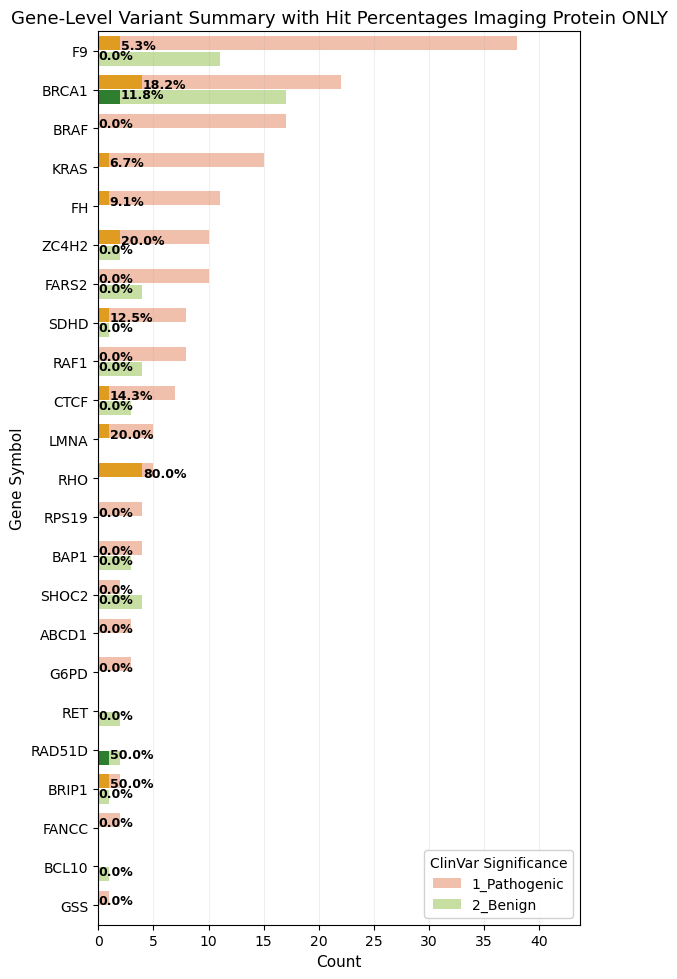

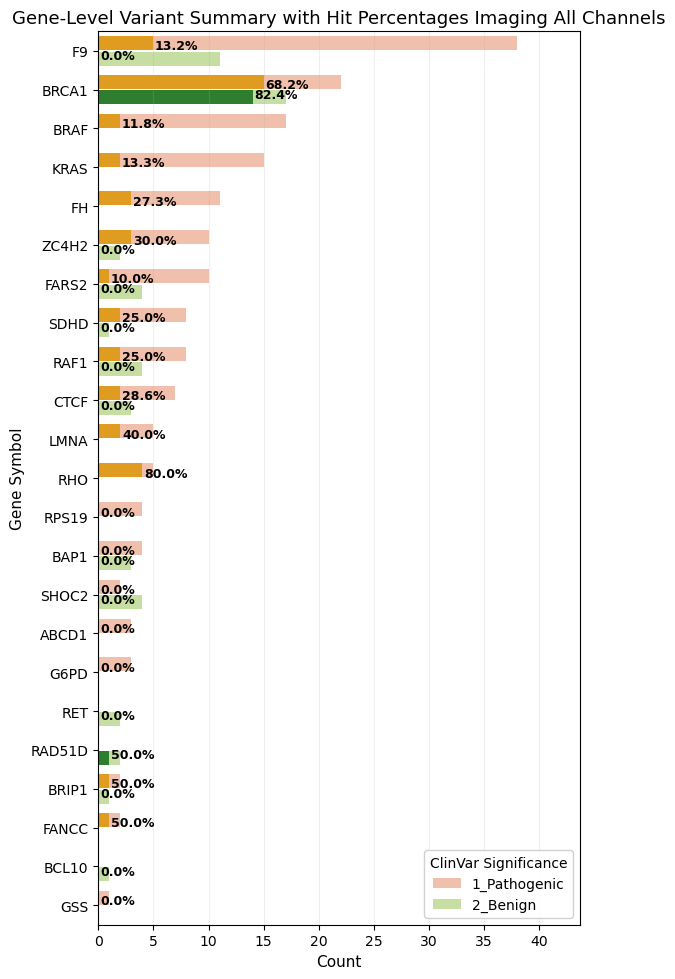

In [74]:
img_clinvar_clean_all = img_metric_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"]) ## ,"3_Conflicting","4_VUS"
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
img_clinvar_clean_hits_prot = img_metric_df.unique("gene_variant").filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])) & (pl.col("img_prot_hits_5perc")) ##,"3_Conflicting","4_VUS"
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_hits_prot = img_clinvar_clean_all.join(
    img_clinvar_clean_hits_prot,
    on=["symbol","clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
img_hits_all_res = plot_gene_level_summary(img_hits_prot, "Imaging Protein ONLY")

img_clinvar_clean_hits_all = img_metric_df.unique("gene_variant").filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])) & (pl.col("img_hits_5perc")) ##,"3_Conflicting","4_VUS"
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_hits_all = img_clinvar_clean_all.join(
    img_clinvar_clean_hits_all,
    on=["symbol","clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
img_hits_all_res = plot_gene_level_summary(img_hits_all, "Imaging All Channels")

In [16]:
### look at the benign hits
img_metric_df.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["2_Benign"])) & (pl.col("img_prot_hits_5perc"))
).unique("gene_variant")["gene_variant","clinvar_clnsig","clinvar_var_source",
                         "AlphaMissense_pred","AlphaMissense_score","ESM1b_score","ESM1b_pred",
                         "ReviewStatus","clinvar_review","ReviewStatusOncogenicity","ReviewStatusClinicalImpact"]

gene_variant,clinvar_clnsig,clinvar_var_source,AlphaMissense_pred,AlphaMissense_score,ESM1b_score,ESM1b_pred,ReviewStatus,clinvar_review,ReviewStatusOncogenicity,ReviewStatusClinicalImpact
str,str,str,str,str,str,str,str,str,str,str
"""BRCA1_Ala102Gly""","""Benign""","""ClinGen:CA002009""","""LB""","""0.1268""","""-4.128""","""T""","""reviewed by expert panel""","""reviewed_by_expert_panel""","""-""","""-"""
"""RAD51D_Glu233Gly""","""Benign/Likely_benign""","""ClinGen:CA293923|UniProtKB:O75…","""A""","""0.4981""","""-7.244""","""T""","""criteria provided, multiple su…","""criteria_provided,_multiple_su…","""-""","""-"""
"""BRCA1_Ser186Tyr""","""Benign""","""BRCA1-HCI:BRCA1_00057|ClinGen:…",""".""",""".""","""-6.751""","""T""","""reviewed by expert panel""","""reviewed_by_expert_panel""","""-""","""-"""


### 1.3 DUAL-IPA and PPI alleles

symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,…,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold,abund_zscore
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool,bool,f64,f64
"""KCNJ2""","""899G>A""","""Gly300Asp""","""KCNJ2_Gly300Asp""",693.679993,5069.049805,0.133067,0.841771,0.15808,-1.835174,-1.0,-5.882805,"""ENSG00000123700""","""CCSBVarC008343""","""ALE00008329""","""NC_000017.11:70175938:G:A""","""Edgotyping3""","""VUSMutGDEh010""","""G06""","""GDEhDisVCh_40005""","""F10""","""1""","""VUSMutGDDh010""","""G06""","""VUSN2Hmut_GDN2h_03""","""H09""","""VUSMutpDEST2_16""","""G04""","""VUSmut_GDEh03""","""H09""",1,2,1,2,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-5.882805
"""HBD""","""174C>A""","""Asn58Lys""","""HBD_Asn58Lys""",33.84,2474.280029,0.012192,0.077713,0.156882,-1.837623,-1.0,-5.907103,"""ENSG00000223609""","""CCSBVarC006560""","""ALE00006559""","""NC_000011.10:5234132:G:T""","""CEGS2""","""CegsMutGDEh1047""","""D02""","""GDEhDisVCh_40036""","""D03""","""2""","""CegsMutGDDh1047""","""D02""","""VUSN2Hmut_GDN2h_10""","""C04""","""VUSMutpDEST2_11""","""H05""","""VUSmut_GDEh10""","""C04""",1,1,1,1,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-5.907103
"""SMAD3""","""376C>T""","""His126Tyr""","""SMAD3_His126Tyr""",993.600037,3757.339966,0.267095,1.033889,0.25834,-1.630252,-1.0,-4.313822,"""ENSG00000166949""","""CCSBVarC007714""","""ALE00007700""","""NC_000015.10:67165064:C:T""","""Edgotyping3""","""VUSMutGDEh004""","""D11""","""GDEhDisVCh_40014""","""D06""","""2""","""VUSMutGDDh004""","""D11""","""NULL""","""NULL""","""VUSMutpDEST2_09""","""B02""","""NULL""","""NULL""",1,1,1,1,0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.884438,-4.313822
"""HBD""","""110C>A""","""Pro37His""","""HBD_Pro37His"

VarChAMP DUAL-IPA assay unique variants: 741


gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,ppi_pert_hits_75
str,i64,i64,i64,i64,f64,f64,f64,f64,i64,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool
"""STXBP1_Lys196Arg""",6,1,3,2,16.67,50.0,33.33,66.67,4,1.9998,true,"""STXBP1""","""ENSG00000136854""",7652,1802,"""CCSBVarC007624""","""ALE00007610""","""NC_000009.12:127665255:A:G""","""587A>G""","""Lys196Arg""","""Edgotyping3""","""VUSMutGDEh008""","""C08""","""GDEhDisVCh_40016""","""A06""","""2""","""VUSMutGDDh008""","""C08""","""VUSN2Hmut_GDN2h_02""","""C08""","""VUSMutpDEST2_06""","""G06""","""VUSmut_GDEh02""","""C08""",1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false
"""RP2_Ile91Leu""",3,2,1,0,66.67,33.33,0.0,100.0,3,0.0,true,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false
"""KRT86_Glu402Gln""",7,3,3,1,42.86,42.86,14.29,85.71,6,1.0003,true,"""KRT86""","""ENSG00000170442""",13939,204120,"""CCSBVarC006578""","""ALE00006577""","""NC_000012.12:52306237:G:C""","""1204G>C""","""Glu402Gln""","""CEGS2""","""CegsMutGDEh1042""","""A10""","""GDEhDisVCh_40039""","""B01""","""1""","""CegsMutGDDh1042""","""A10""","""VUSN2Hmut_GDN2h_09""","""D01""","""NULL""","""NULL""","""VUSmut_GDEh09""","""D01""",1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false
"""RAD51D_Val66Met""",19,17,1,1,89.47,5.26,5.26,94.74,18,0.9994,true,"""RAD51D""",null,7201,null,"""CCSBVarC024804""",null,"""NC_000017.11:35118568:C:T""",null,"""Val66Met""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nu

VarChAMP DUAL-IPA assay unique variants: 819
VarChAMP DUAL-IPA and PPI assay unique variants: 1279


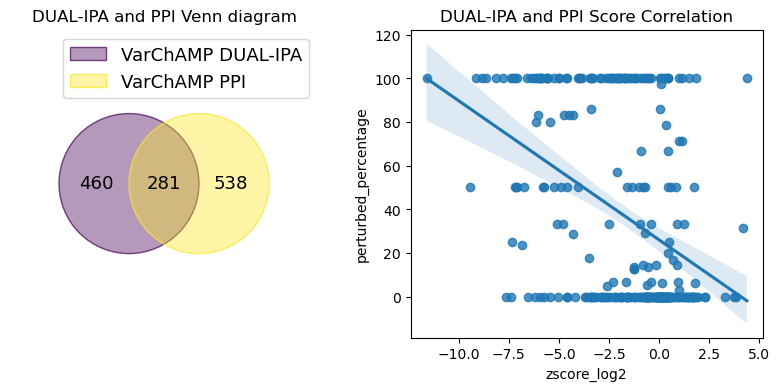

In [75]:
dual_ipa_df = pl.read_csv("../1_inputs/dual_ipa/abun_scores.csv", infer_schema_length=1000000)
dual_ipa_df = dual_ipa_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
)
display(dual_ipa_df)
print("VarChAMP DUAL-IPA assay unique variants:", dual_ipa_df.unique(subset=["gene_variant"]).shape[0])

ppi_sum_df = pl.read_csv("../1_inputs/ppi/edgotyping_perturb_sum_stats.csv", infer_schema_length=1000000)
ppi_threshold = 75
ppi_sum_df = ppi_sum_df.with_columns(
    (pl.col("perturbed_percentage")>=ppi_threshold).alias(f"ppi_pert_hits_{ppi_threshold}"),
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
)
display(ppi_sum_df)
print("VarChAMP DUAL-IPA assay unique variants:", ppi_sum_df.unique(subset=["gene_variant"]).shape[0])

## merge the two assays by gene_variant
dual_ppi_df = dual_ipa_df.join(
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)
print("VarChAMP DUAL-IPA and PPI assay unique variants:", dual_ppi_df.unique(subset=["gene_variant"]).shape[0])

dual_ppi_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
}

fig, axes = plt.subplots(1,2,figsize=(10,4))
venn(dual_ppi_set, ax=axes[0])
sns.regplot(data=dual_ppi_df.to_pandas(),
            x="zscore_log2",
            y="perturbed_percentage",
           ax=axes[1])
axes[0].set_title("DUAL-IPA and PPI Venn diagram")
axes[1].set_title("DUAL-IPA and PPI Score Correlation")
plt.show()

### 1.3.1 DUAL-IPA hits

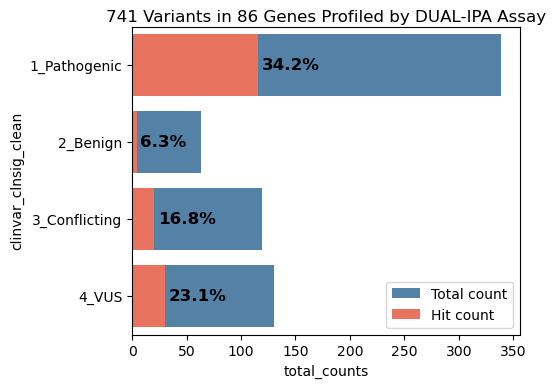

In [78]:
dual_ipa_all = dual_ipa_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
dual_ipa_hits_all = dual_ipa_df.unique("gene_variant").filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & (pl.col("dualipa_abund_change"))
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
dualipa_hits_all = dual_ipa_all.join(
    dual_ipa_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
dualipa_hits_all.sort("clinvar_clnsig_clean")

plot_df = dualipa_hits_all.sort("clinvar_clnsig_clean").to_pandas()
fig, axes = plt.subplots(1,1,figsize=(5,4))

sns.barplot(plot_df,label="Total count", color="steelblue",
           y="clinvar_clnsig_clean",x="total_counts", ax=axes)
sns.barplot(plot_df, label="Hit count",
           y="clinvar_clnsig_clean",x="hit_counts", color="tomato")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes.text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
axes.set_title(f"{dual_ipa_df.unique('gene_variant').shape[0]} Variants in {dual_ipa_df.unique('Gene').shape[0]-1} Genes Profiled by DUAL-IPA Assay", y=.99)
ax.grid(alpha=.2)

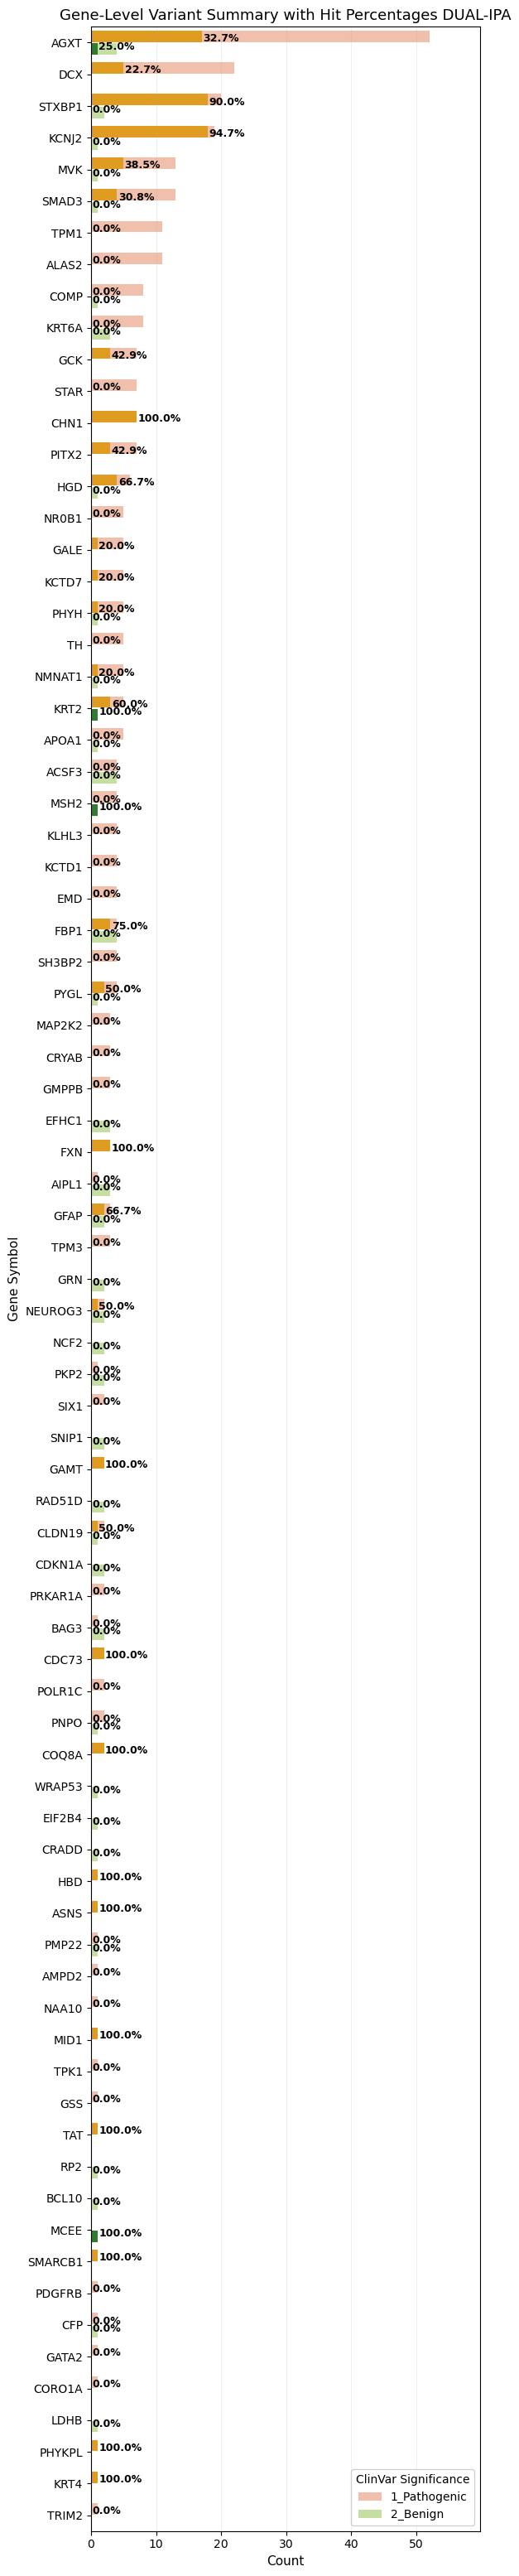

In [86]:
dual_clean_all = dual_ipa_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"]) ## ,"3_Conflicting","4_VUS"
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
dual_clean_hits_all = dual_ipa_df.unique("gene_variant").filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])) & (pl.col("dualipa_abund_change")) ##,"3_Conflicting","4_VUS"
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
dual_hits_all = dual_clean_all.join(
    dual_clean_hits_all,
    on=["symbol","clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)

dual_hits_all_res = plot_gene_level_summary(dual_hits_all, "DUAL-IPA")

### 1.3.2 PPI Perturbation Percentage hits

Text(0.5, 0.99, '819 Variants in 89 Genes Profiled by PPI Assay')

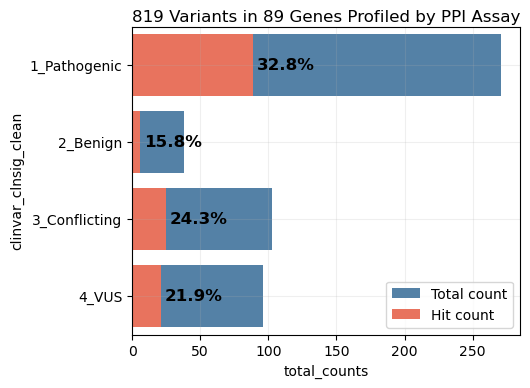

In [80]:
ppi_sum_df_all = ppi_sum_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
ppi_sum_df_hits_all = ppi_sum_df.unique("gene_variant").filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & (pl.col(f"ppi_pert_hits_{ppi_threshold}"))
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
ppi_hits_all = ppi_sum_df_all.join(
    ppi_sum_df_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
ppi_hits_all.sort("clinvar_clnsig_clean")

plot_df = ppi_hits_all.sort("clinvar_clnsig_clean").to_pandas()
fig, ax = plt.subplots(1,1,figsize=(5,4))
sns.barplot(plot_df,label="Total count", color="steelblue",
           y="clinvar_clnsig_clean",x="total_counts", ax=ax)
sns.barplot(plot_df, label="Hit count",
           y="clinvar_clnsig_clean",x="hit_counts", color="tomato", ax=ax)
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    ax.text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
ax.grid(alpha=.2)
ax.set_title(f"{ppi_sum_df.unique('gene_variant').shape[0]} Variants in {ppi_sum_df.unique('Gene').shape[0]-1} Genes Profiled by PPI Assay", y=.99)

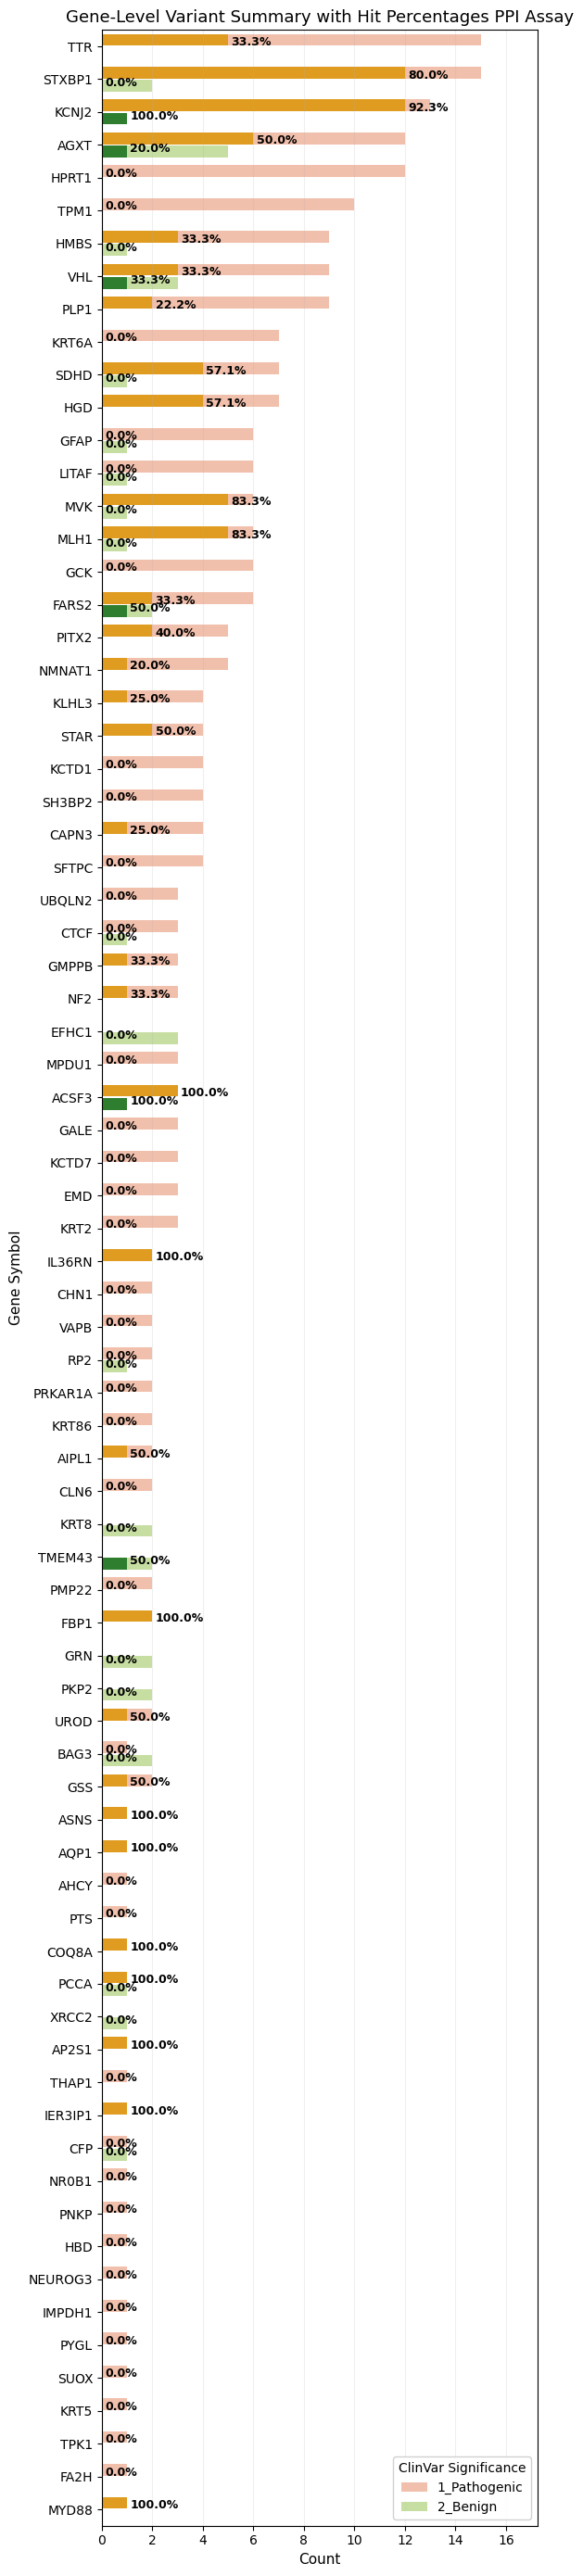

In [28]:
ppi_clean_all = ppi_sum_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"]) ## ,"3_Conflicting","4_VUS"
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
ppi_clean_hits_all = ppi_sum_df.unique("gene_variant").filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])) & (pl.col(f"ppi_pert_hits_{ppi_threshold}")) ##,"3_Conflicting","4_VUS"
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
ppi_hits_all = ppi_clean_all.join(
    ppi_clean_hits_all,
    on=["symbol","clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)

ppi_hits_all_res = plot_gene_level_summary(ppi_hits_all, "PPI Assay")

## 1.4 Merging all three assays

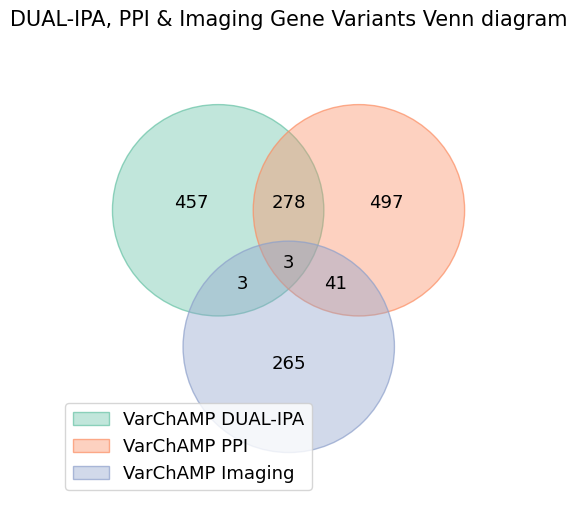

In [81]:
# Create the diagrams with your data
dual_ppi_img_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique())
}
venn(dual_ppi_img_set, figsize=(6,8), legend_loc="lower left", 
     cmap=sns.color_palette("Set2") ## dict(zip(dual_ppi_img_set.keys(), sns.color_palette("Set2"))
)
plt.title("DUAL-IPA, PPI & Imaging Gene Variants Venn diagram", fontsize=15, y=1.)
plt.show()

In [83]:
img_dual_ppi_df = img_metric_df.select(
    ["gene_variant"] + [c for c in img_metric_df.columns if c not in varchamp_pillar_df.columns]
).join(
    dual_ipa_df.select(
        ["gene_variant"] + [c for c in dual_ipa_df.columns if c not in varchamp_pillar_df.columns]
    ),
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_dualipa"
).join( ## .unique(subset=["gene_variant"])
    ppi_sum_df.select(
        ["gene_variant"] + [c for c in ppi_sum_df.columns if c not in varchamp_pillar_df.columns]
    ),
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)

img_dual_ppi_df = img_dual_ppi_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene_symbol"),
).join(
    varchamp_pillar_df,
    on="gene_variant",
    how="left"
).with_columns(
    pl.col("clinvar_clnsig_clean").fill_null("6_No_ClinVar").alias("clinvar_clnsig_clean")
).unique("gene_variant")
img_dual_ppi_df

gene_variant,gene_allele,cc_t_stat,cc_p_val,abun_t_stat,abun_p_val,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,img_prot_hits_5perc,img_hits_5perc,img_hits_1perc,median_gfp,…,clinvar_star,auth_reported_rep_score,Mode of Inheritance_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,aa_change_pp,Evidence Repo Link_ClinGen_repo,Interval 2 name,Interval 6 range,Interval 1 range,Rationale_presumed_PMID:34273903,aa_alt,clinvar_date_last_reviewed,auth_transcript_id,Interval 2 range,Naive_prior_prob_PMID:31131967,Approval Date_ClinGen_repo,simplified_consequence,Expert Panel_ClinGen_repo,aa_pos,transcript_ref,Disease_ClinGen_repo,gnomad_MAF,auth_reported_score,Interval 1 MaveDB class,clinvar_sig,hg38_start,consequence,Interval 5 MaveDB class,REVEL,auth_reported_func_class,Interval 3 name,Family History LR_PMID:31131967,PubMed Articles_ClinGen_repo,Assay_type,Interval 4 range,Calcualted_post_prob_PMID:31131967,gene_variant_pp
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,str,str,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,str,str,f64,str
"""PYGL_Asn632Ile""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,586.040039,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""MVK_Arg106His""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3553.960083,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""HPRT1_Asp80Val""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""RAD51D_Ile17Val""","""RAD51D_Ile17Val""",0.829719,0.434077,15.438749,0.000001,"""2025_01_Batch_13-14""",0.84624,0.9108,0.967766,0.906131,0.855815,0.87237,0.896112,0.954403,0.932828,0.786509,0.859305,0.903456,0.961084,0.91948,0.821162,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,true,true,false,null,…,"""criteria provided, conflicting…",null,null,null,"""Ile17Val""",null,null,null,null,null,"""V""","""Jul 11, 2024""",null,null,null,null,"""missense_variant""",null,17.0,"""A""",null,0.000008,-0.02069,null,"""Conflicting classifications of…",3.5119565e7,"""missense_variant""",null,0.028,"""functionally_normal""",null,null,null,"""Cell viability""",null,null,"""RAD51D_Ile17Val"""
"""PLP1_Ile152Thr""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,

In [82]:
img_dual_ppi_df.unique("Gene_symbol")

gene_variant,gene_allele,cc_t_stat,cc_p_val,abun_t_stat,abun_p_val,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,img_prot_hits_5perc,img_hits_5perc,img_hits_1perc,median_gfp,…,clinvar_star,auth_reported_rep_score,Mode of Inheritance_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,aa_change_pp,Evidence Repo Link_ClinGen_repo,Interval 2 name,Interval 6 range,Interval 1 range,Rationale_presumed_PMID:34273903,aa_alt,clinvar_date_last_reviewed,auth_transcript_id,Interval 2 range,Naive_prior_prob_PMID:31131967,Approval Date_ClinGen_repo,simplified_consequence,Expert Panel_ClinGen_repo,aa_pos,transcript_ref,Disease_ClinGen_repo,gnomad_MAF,auth_reported_score,Interval 1 MaveDB class,clinvar_sig,hg38_start,consequence,Interval 5 MaveDB class,REVEL,auth_reported_func_class,Interval 3 name,Family History LR_PMID:31131967,PubMed Articles_ClinGen_repo,Assay_type,Interval 4 range,Calcualted_post_prob_PMID:31131967,gene_variant_pp
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,str,str,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,str,str,f64,str
"""HBD_Glu44Gly""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,44.18,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""SMAD3_Glu50Lys""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1567.680054,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""PHYKPL_Gly240Arg""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,747.110046,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""CTCF_Ala697Thr""","""CTCF_Ala697Thr""",-1.123277,0.298362,1.48872,0.180168,"""2025_01_Batch_13-14""",0.427812,0.524164,0.586791,0.502066,0.457358,0.549837,0.693146,0.564469,0.676349,0.464807,0.488825,0.608655,0.57563,0.589207,0.461082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,false,false,false,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""BAP1_Arg718Gln""","""BAP1_Arg718Gln""",-0.945816,0.375738,-3.420989,0.01112,"""2025_01_Batch_13-14""",0.617234,0.632468,0.666608,0.57009,0.555247,0.567699,0.577043,0.657552,0.623374,0.571671,0.592466,0.604755,0.66208,0.596732,0.563459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,false,false,false,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,

In [31]:
img_dual_ppi_df.group_by("clinvar_clnsig_clean").agg(
    pl.len()
).sort("clinvar_clnsig_clean")

clinvar_clnsig_clean,len
str,u32
null,50
"""1_Pathogenic""",669
"""2_Benign""",174
"""3_Conflicting""",233
"""4_VUS""",340
"""5_Others""",78


In [39]:
with pl.Config(set_tbl_rows=50):
    display(
        img_dual_ppi_df.filter(pl.col("Gene_symbol")=="BRCA1").select(
            pl.col(["gene_variant","clinvar_clnsig_clean",]+[f"Altered_95th_perc_{feat}" for feat in IMG_FEAT_SET]+[f"AUROC_Mean_{feat}" for feat in IMG_FEAT_SET]+[f"Interval {i} MaveDB class" for i in range(1,7)])
        ).sort(f"clinvar_clnsig_clean").filter(
            pl.col("gene_variant")!="BRCA1_Thr616Ala"
        ).rename(
            dict(zip(
                [f"Altered_95th_perc_{feat}" for feat in IMG_FEAT_SET],
                [f"Altered_{feat}" for feat in IMG_FEAT_SET]
            ))
        ).with_columns(
            [pl.col(col).cast(pl.Boolean).alias(col) for col in [f"Altered_{feat}" for feat in IMG_FEAT_SET]]
        )
    )

gene_variant,clinvar_clnsig_clean,Altered_GFP,Altered_Morph,Altered_DNA,Altered_Mito,Altered_AGP,AUROC_Mean_GFP,AUROC_Mean_Morph,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,Interval 1 MaveDB class,Interval 2 MaveDB class,Interval 3 MaveDB class,Interval 4 MaveDB class,Interval 5 MaveDB class,Interval 6 MaveDB class
str,str,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,str,str,str,str,str,str
"""BRCA1_Cys44Tyr""","""1_Pathogenic""",false,false,false,false,false,0.867561,0.887674,0.786306,0.894696,0.889821,null,null,null,null,null,null
"""BRCA1_Cys64Ser""","""1_Pathogenic""",false,false,false,false,false,0.745238,0.619878,0.558145,0.720455,0.627797,null,null,null,null,null,null
"""BRCA1_Cys39Arg""","""1_Pathogenic""",false,true,false,false,false,0.915553,0.938289,0.860444,0.949344,0.915395,null,null,null,null,null,null
"""BRCA1_Arg71Lys""","""1_Pathogenic""",false,true,false,false,true,0.896138,0.956379,0.825656,0.938486,0.938558,null,null,null,null,null,null
"""BRCA1_Ser611Arg""","""1_Pathogenic""",false,true,true,true,true,0.914962,0.968193,0.88663,0.964238,0.945209,null,null,null,null,null,null
"""BRCA1_Met1Ile""","""1_Pathogenic""",true,true,true,true,true,0.987895,0.953985,0.906508,0.986637,0.94184,null,null,null,null,null,null
"""BRCA1_Thr581Ile""","""1_Pathogenic""",false,true,false,true,false,0.921312,0.955578,0.857109,0.967036,0.918189,"""Normal""","""Abnormal""","""Not specified""",null,null,null
"""BRCA1_Thr37Lys""","""1_Pathogenic""",false,false,false,false,false,0.893538,0.876968,0.803321,0.916768,0.892236,null,null,null,null,null,null
"""BRCA1_Thr587Arg""","""1_Pathogenic""",false,true,true,false,false,0.892647,0.918323,0.824658,0.927567,0.902222,null,null,null,null,null,null


In [84]:
35+29+6

70

In [40]:
img_dual_ppi_df.filter(pl.col("Gene_symbol")=="BRCA1").select(
    pl.col(["gene_variant","clinvar_clnsig_clean",]+[f"Altered_95th_perc_{feat}" for feat in IMG_FEAT_SET]+[f"AUROC_Mean_{feat}" for feat in IMG_FEAT_SET]+[f"Interval {i} MaveDB class" for i in range(1,7)])
).sort(f"clinvar_clnsig_clean").filter(
    pl.col("gene_variant")!="BRCA1_Thr616Ala"
).rename(
    dict(zip(
        [f"Altered_95th_perc_{feat}" for feat in IMG_FEAT_SET],
        [f"Altered_{feat}" for feat in IMG_FEAT_SET]
    ))
).with_columns(
    [pl.col(col).cast(pl.Boolean).alias(col) for col in [f"Altered_{feat}" for feat in IMG_FEAT_SET]]
).write_csv("BRCA1_allele_img_results.csv")

In [30]:
img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))&(pl.col("dualipa_assayed")))

gene_variant,gene_allele,cc_t_stat,cc_p_val,abun_t_stat,abun_p_val,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,img_prot_hits_5perc,img_hits_5perc,img_hits_1perc,median_gfp,…,clinvar_star,auth_reported_rep_score,Mode of Inheritance_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,aa_change_pp,Evidence Repo Link_ClinGen_repo,Interval 2 name,Interval 6 range,Interval 1 range,Rationale_presumed_PMID:34273903,aa_alt,clinvar_date_last_reviewed,auth_transcript_id,Interval 2 range,Naive_prior_prob_PMID:31131967,Approval Date_ClinGen_repo,simplified_consequence,Expert Panel_ClinGen_repo,aa_pos,transcript_ref,Disease_ClinGen_repo,gnomad_MAF,auth_reported_score,Interval 1 MaveDB class,clinvar_sig,hg38_start,consequence,Interval 5 MaveDB class,REVEL,auth_reported_func_class,Interval 3 name,Family History LR_PMID:31131967,PubMed Articles_ClinGen_repo,Assay_type,Interval 4 range,Calcualted_post_prob_PMID:31131967,gene_variant_pp
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,f64,str,str,f64,f64,str,str,f64,str,str,f64,str,str,f64,str,str,str,f64,str
"""GSS_Arg125Cys""","""GSS_Arg125Cys""",4.177443,0.00415,-2.753966,0.028341,"""2025_01_Batch_13-14""",0.602072,0.653072,0.763212,0.7237,0.566457,0.539237,0.619455,0.548967,0.649187,0.499309,0.570654,0.636264,0.656089,0.686444,0.532883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,false,false,false,5849.025146,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""AGXT_Asp201Asn""","""AGXT_Asp201Asn""",-6.422474,0.00036,-4.29278,0.003598,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,null,null,null,635.179993,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""BCL10_Leu8Leu""","""BCL10_Leu8Leu""",-1.593538,0.186262,1.756003,0.122515,"""2025_01_Batch_13-14""",0.535754,0.635298,0.663309,0.691869,0.493863,0.882353,0.759233,0.764702,0.821239,0.579186,0.709053,0.697265,0.714005,0.756554,0.536524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,false,false,false,3546.090088,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


<Axes: xlabel='AUROC_Mean_GFP', ylabel='perturbed_percentage'>

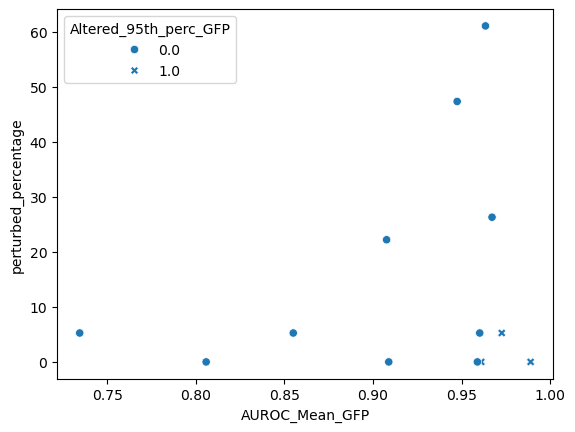

In [95]:
# sns.regplot(data=img_dual_ppi_df.filter(pl.col("Gene")=="RAD51D").to_pandas(),
#            x="AUROC_Mean_GFP",y="perturbed_percentage")
sns.scatterplot(data=img_dual_ppi_df.filter(pl.col("Gene")=="RAD51D").to_pandas(),
           x="AUROC_Mean_GFP",y="perturbed_percentage", style="Altered_95th_perc_GFP")

In [99]:
with pl.Config(set_tbl_rows=30):
    display(
        img_dual_ppi_df.filter(pl.col("Gene")=="RAD51D")["gene_variant","Altered_95th_perc_GFP","AUROC_Mean_GFP","perturbed_percentage"].sort("AUROC_Mean_GFP", descending=True)
    )

gene_variant,Altered_95th_perc_GFP,AUROC_Mean_GFP,perturbed_percentage
str,f64,f64,f64
"""RAD51D_Thr27Lys""",null,null,50.0
"""RAD51D_Phe305Leu""",null,null,0.0
"""RAD51D_Met308Val""",1.0,0.989016,0.0
"""RAD51D_Asn138His""",1.0,0.975975,null
"""RAD51D_Thr328Ile""",1.0,0.972711,5.26
"""RAD51D_Glu307Lys""",0.0,0.967229,26.32
"""RAD51D_Glu233Gly""",1.0,0.964322,null
"""RAD51D_Val132Ile""",0.0,0.963528,61.11
"""RAD51D_Ala231Ser""",1.0,0.961174,0.0


In [202]:
# img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).group_by("Gene").agg(
#     pl.col("Gene").len().alias("Count")
# )
# sns.scatterplot(data=img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).to_pandas(),
#                 x="AUROC_Mean_Morph",
#                 y="perturbed_percentage",
#                 style="Altered_95th_perc_Morph")

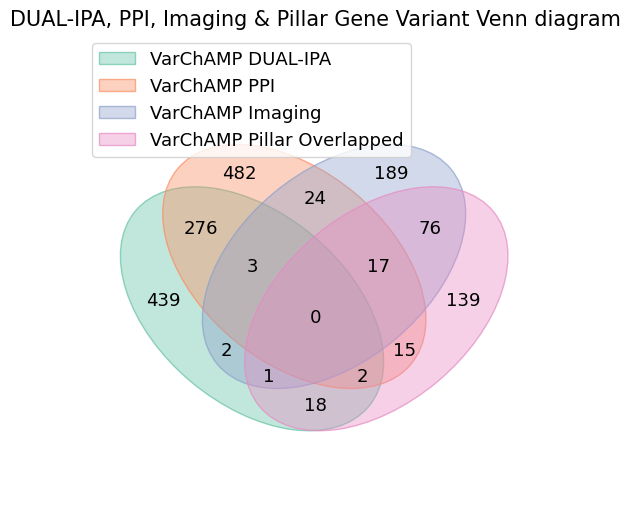

In [85]:
## Create the diagrams with your data
sets_data = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP Pillar Overlapped': set(varchamp_pillar_df.filter(pl.col("pillar_tested"))["gene_variant"].unique()),
}

venn(sets_data, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Gene Variant Venn diagram", fontsize=15, y=1.)
plt.show()

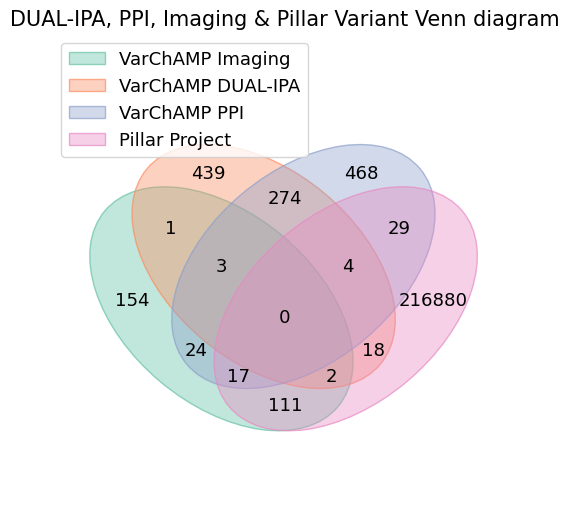

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,ppi_pert_hits_75
str,i64,i64,i64,i64,f64,f64,f64,f64,i64,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool
"""XRCC2_Phe270Val""",2,1,1,0,50.0,50.0,0.0,100.0,2,0.0,true,"""XRCC2""","""ENSG00000196584""",13571,218098,"""CCSBVarC005690""","""ALE00005690""","""NC_000007.14:152648677:A:C""","""808T>G""","""Phe270Val""","""CEGS2""","""CegsMutGDEh1030""","""D06""","""GDEhDisVCh_40090""","""A05""","""2""","""CegsMutGDDh1030""","""D06""","""VUSN2Hmut_GDN2h_05""","""D04""","""VUSMutpDEST2_11""","""H04""","""VUSmut_GDEh05""","""D04""",1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false


In [33]:
pillar_varchamp_df_variant_reannot = pillar_varchamp_df.with_columns(
    pl.when((pl.col("varchamp_collection")))
    .then(pl.col("gene_variant_vc"))
    .otherwise(pl.col("gene_variant"))
    .alias("gene_variant")
)
# Create the diagrams with your data
sets_data_variant_all_pillar = {
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'Pillar Project': set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"].unique()),
}

venn(sets_data_variant_all_pillar, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Variant Venn diagram", fontsize=15, y=1.)
plt.show()
# ppi_sum_df.filter(pl.col("symbol")=="XRCC2") ## same gene, different variants

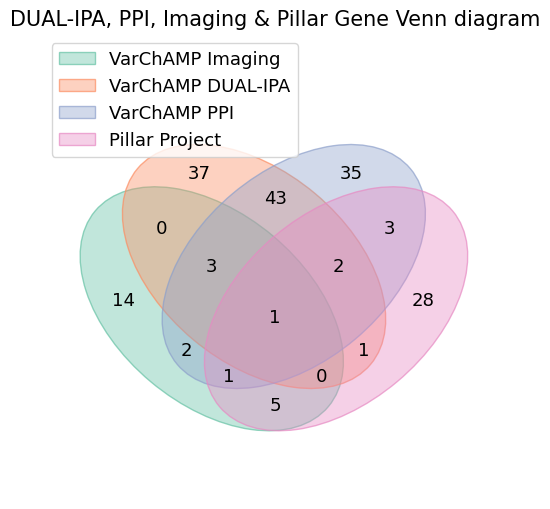

In [34]:
# Create the diagrams with your data
sets_data_gene_all_pillar = {
    'VarChAMP Imaging': set(img_metric_df["Gene"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["Gene"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["Gene"].unique()),
    'Pillar Project': set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["Gene"].unique()),
}

venn(sets_data_gene_all_pillar, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Gene Venn diagram", fontsize=15, y=1.)
plt.show()

In [233]:
# Method 1: using set.intersection
# common_genes = set.intersection(set(img_metric_df["symbol"].unique()).union(set(dual_ipa_df["symbol"].unique())).union(set(ppi_sum_df["symbol"].unique())),
#                                 set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["Gene"].unique()))
# set(ppi_sum_df.filter(pl.col("gene_variant").str.contains("RAD51D"))["gene_variant"].unique()).intersection(
#     set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"].unique())
# )

{'RAD51D_Ala231Ser',
 'RAD51D_Cys9Ser',
 'RAD51D_Glu307Lys',
 'RAD51D_Gly289Ser',
 'RAD51D_His23Arg',
 'RAD51D_Ile251Val',
 'RAD51D_Met308Val',
 'RAD51D_Phe305Leu',
 'RAD51D_Thr27Lys',
 'RAD51D_Thr328Ile',
 'RAD51D_Val132Ile',
 'RAD51D_Val28Leu',
 'RAD51D_Val56Gly',
 'RAD51D_Val66Leu',
 'RAD51D_Val66Met'}

In [47]:
# Method 1: using set.intersection
common_variants = set.intersection(set(img_metric_df["gene_variant"].unique()).union(set(dual_ipa_df["gene_variant"].unique())).union(set(ppi_sum_df["gene_variant"].unique())),
                  set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"].unique()))
# set(ppi_sum_df.filter(pl.col("gene_variant").str.contains("RAD51D"))["gene_variant"].unique()).intersection(
#     set(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"].unique())
# )

In [48]:
print(len(common_variants))

181


In [38]:
set([gene_variant.split("_")[0] for gene_variant in common_variants])

{'BAP1',
 'BRCA1',
 'CTCF',
 'F9',
 'G6PD',
 'GCK',
 'HMBS',
 'MSH2',
 'RAD51D',
 'RHO',
 'TPK1',
 'VHL'}

In [64]:
# # Create the diagrams with your data
# sets_data_gene = {
#     'VarChAMP Imaging': set(img_metric_df["symbol"].unique()), 
#     'VarChAMP DUAL-IPA': set(dual_ipa_df["symbol"].unique()),
#     'VarChAMP PPI': set(ppi_sum_df["symbol"].unique()),
#     'VarChAMP Pillar Overlapped': set(varchamp_pillar_df.filter(pl.col("pillar_tested"))["symbol"].unique()),
# }
# venn(sets_data_gene, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
# plt.title("DUAL-IPA, PPI, Imaging & Pillar Gene Venn diagram", fontsize=15, y=1.)
# plt.show()

Text(0.5, 1.0, 'Number of Variants per Each Overlapped Gene with DMS dataset')

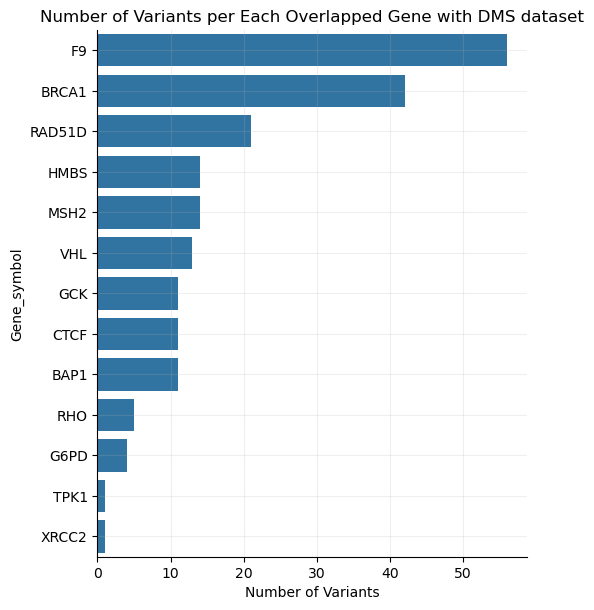

In [43]:
g = sns.catplot(data=img_dual_ppi_df.filter(
    (pl.col("Gene_symbol").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["Gene"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
).unique(
    "gene_variant"
).group_by("Gene_symbol").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene_symbol", kind="bar", height=6, aspect=.9)
g.ax.grid(alpha=.2)
plt.title("Number of Variants per Each Overlapped Gene with DMS dataset")

Text(0.5, 1.0, 'Number of Overlapped Variants per Gene in Both Allele Collections')

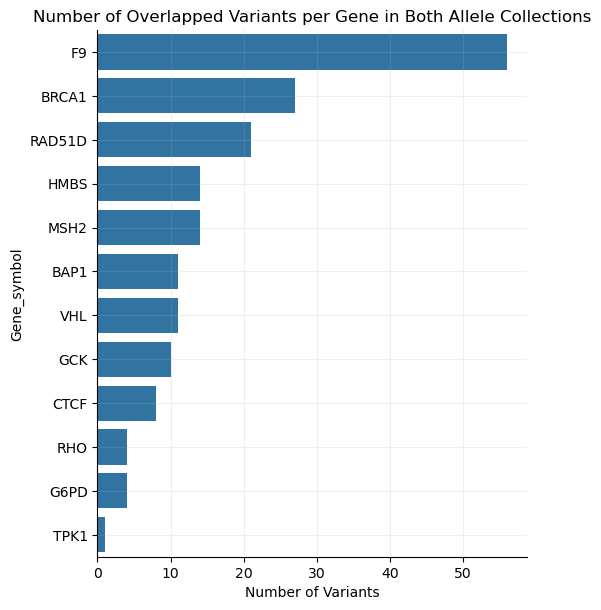

In [44]:
g = sns.catplot(data=img_dual_ppi_df.filter(
    (pl.col("gene_variant").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
).unique(
    "gene_variant"
).group_by("Gene_symbol").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene_symbol", kind="bar", height=6, aspect=.9)
g.ax.grid(alpha=.2)
plt.title("Number of Overlapped Variants per Gene in Both Allele Collections")

In [46]:
img_dual_ppi_df.filter(
    (pl.col("gene_variant").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
).unique(
    "gene_variant"
).group_by("Gene_symbol").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas().sum()

Gene_symbol           F9BRCA1RAD51DMSH2HMBSVHLBAP1GCKCTCFG6PDRHOTPK1
Number of Variants                                               181
dtype: object

In [87]:
img_feats = [f"AUROC_Mean_{feat}" for feat in IMG_FEAT_SET]+[f"Altered_95th_perc_{feat}" for feat in IMG_FEAT_SET]
dualipa_feats = ["dualipa_abund_change", "dualipa_threshold", "abund_zscore"]
ppi_feats = ["total_occurrences","not_perturbed_count","inconclusive_count","perturbed_count",
             "not_perturbed_percentage","inconclusive_percentage","perturbed_percentage"]
rename_dict = {
    "abund_zscore": "dualipa_abund_zscore",
}
for feat in img_feats:
    rename_dict[feat] = "imaging_"+feat
for feat in ppi_feats:
    rename_dict[feat] = "ppi_"+feat
    
img_dual_ppi_pillar_df = img_dual_ppi_df.filter(
    (pl.col("gene_variant").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
).select(
    ["gene_variant","clinvar_clnsig_clean","spdi"]+img_feats+dualipa_feats+ppi_feats
).rename(rename_dict)

img_dual_ppi_pillar_df.write_csv("../3_outputs/img_dual_ppi_dms_overlapped_alleles.csv")

In [88]:
img_dual_ppi_pillar_df

gene_variant,clinvar_clnsig_clean,spdi,imaging_AUROC_Mean_GFP,imaging_AUROC_Mean_Morph,imaging_AUROC_Mean_DNA,imaging_AUROC_Mean_Mito,imaging_AUROC_Mean_AGP,imaging_Altered_95th_perc_GFP,imaging_Altered_95th_perc_Morph,imaging_Altered_95th_perc_DNA,imaging_Altered_95th_perc_Mito,imaging_Altered_95th_perc_AGP,dualipa_abund_change,dualipa_threshold,dualipa_abund_zscore,ppi_total_occurrences,ppi_not_perturbed_count,ppi_inconclusive_count,ppi_perturbed_count,ppi_not_perturbed_percentage,ppi_inconclusive_percentage,ppi_perturbed_percentage
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,f64,f64,i64,i64,i64,i64,f64,f64,f64
"""F9_Phe395Ile""","""1_Pathogenic""","""NC_000023.11:139561868:T:A""",0.875349,0.649607,0.658657,0.85295,0.759263,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null
"""RAD51D_Glu233Gly""","""2_Benign""","""NC_000017.11:35103294:T:C""",0.964322,0.674513,0.705775,0.919104,0.885253,1.0,0.0,0.0,0.0,0.0,false,-2.884438,1.286316,null,null,null,null,null,null,null
"""BRCA1_Cys64Tyr""","""1_Pathogenic""","""NC_000017.11:43106477:C:T""",0.922977,0.930471,0.805035,0.873185,0.961233,0.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null
"""G6PD_Gly378Ser""","""3_Conflicting""","""NC_000023.11:154532722:C:T""",0.696318,0.472079,0.489431,0.615492,0.560513,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null
"""BRCA1_Pro533Leu""","""2_Benign""","""NC_000017.11:43071004:G:A""",0.886511,0.943972,0.855476,0.934251,0.908372,0.0,1.0,1.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MSH2_Leu421Pro""","""4_VUS""","""NC_000002.12:47429927:T:C""",null,null,null,null,null,null,null,null,null,null,false,-2.884438,-0.021206,null,null,null,null,null,null,null
"""HMBS_Ala252Val""","""1_Pathogenic""","""NC_000011.10:119092507:C:T""",null,null,null,null,null,null,null,null,null,null,null,null,null,1,0,0,1,0.0,0.0,100.0
"""HMBS_His256Asn""","""1_Pathogenic""","""NC_000011.10:119092518:C:A""",null,null,null,null,null,null,null,null,null,null,null,null,null,1,1,0,0,100.0,0.0,0.0


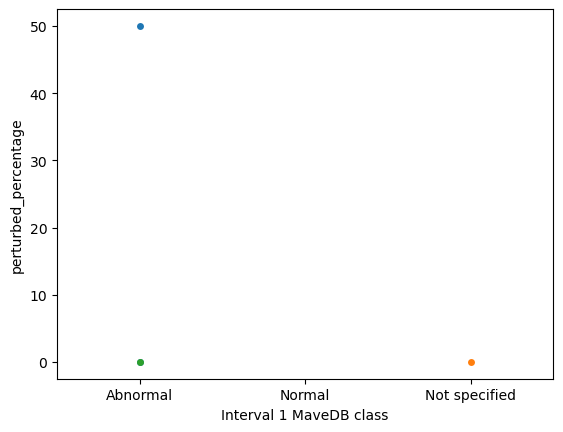

In [90]:
for i in range(1,7):
    sns.swarmplot(
        data=img_dual_ppi_df.filter(
            (pl.col("gene_variant").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
        ).to_pandas(),
        x=f"Interval {i} MaveDB class",
        y="perturbed_percentage"
    )

## 2. Hits calling

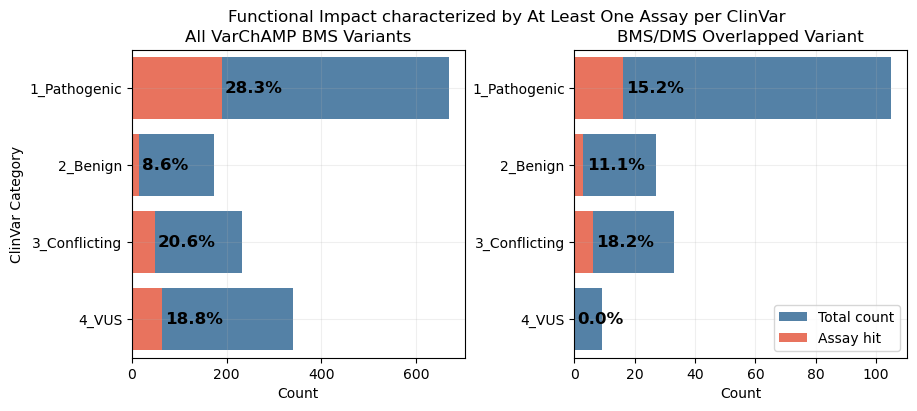

In [71]:
img_dual_ppi_df = img_dual_ppi_df.with_columns(
    pl.any_horizontal(["img_prot_hits_5perc", f"ppi_pert_hits_{ppi_threshold}", "dualipa_abund_change"]).alias("assay_hit")
)

img_dual_ppi_clinvar_clean_all = img_dual_ppi_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_dual_ppi_clinvar_clean_hits_all = img_dual_ppi_df.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & (pl.col("assay_hit"))
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_dual_ppi_by_gene_cv_hits_all = img_dual_ppi_clinvar_clean_all.join(
    img_dual_ppi_clinvar_clean_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
# img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean")

fig, axes = plt.subplots(1,2,figsize=(10,4))
plot_df = img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="total_counts", ax=axes[0], color="steelblue")
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="hit_counts", color="tomato", ax=axes[0])
axes[0].set_title("All VarChAMP BMS Variants")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[0].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
axes[0].grid(alpha=.2)

img_dual_ppi_clinvar_clean_all = img_dual_ppi_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
    & pl.col("gene_variant").is_in(common_variants)
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_dual_ppi_clinvar_clean_hits_all = img_dual_ppi_df.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & (pl.col("assay_hit"))
    & pl.col("gene_variant").is_in(common_variants)
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_dual_ppi_by_gene_cv_hits_all = img_dual_ppi_clinvar_clean_all.join(
    img_dual_ppi_clinvar_clean_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean")

plot_df = img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="total_counts", ax=axes[1],
           label="Total count", color="steelblue")
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="hit_counts", ax=axes[1],
           label="Assay hit", color="tomato")
axes[1].set_title("BMS/DMS Overlapped Variant")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[1].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")

img_dual_ppi_clinvar_clean_all = img_dual_ppi_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
    & pl.col("gene_variant").is_in(common_variants)
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
axes[1].legend(loc="lower right")
axes[1].grid(alpha=.2)
axes[1].set_ylabel("")

axes[0].set_ylabel("ClinVar Category")
axes[1].set_xlabel("Count")
axes[0].set_xlabel("Count")

plt.suptitle("Functional Impact characterized by At Least One Assay per ClinVar")
plt.subplots_adjust(wspace=0.33)

In [269]:
img_dual_ppi_clinvar_clean = img_dual_ppi_df.filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_dual_ppi_clinvar_clean_hits = img_dual_ppi_df.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])) & (pl.col("assay_hit"))
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)

img_dual_ppi_by_gene_cv_hits = img_dual_ppi_clinvar_clean.join(
    img_dual_ppi_clinvar_clean_hits,
    on=["symbol","clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)

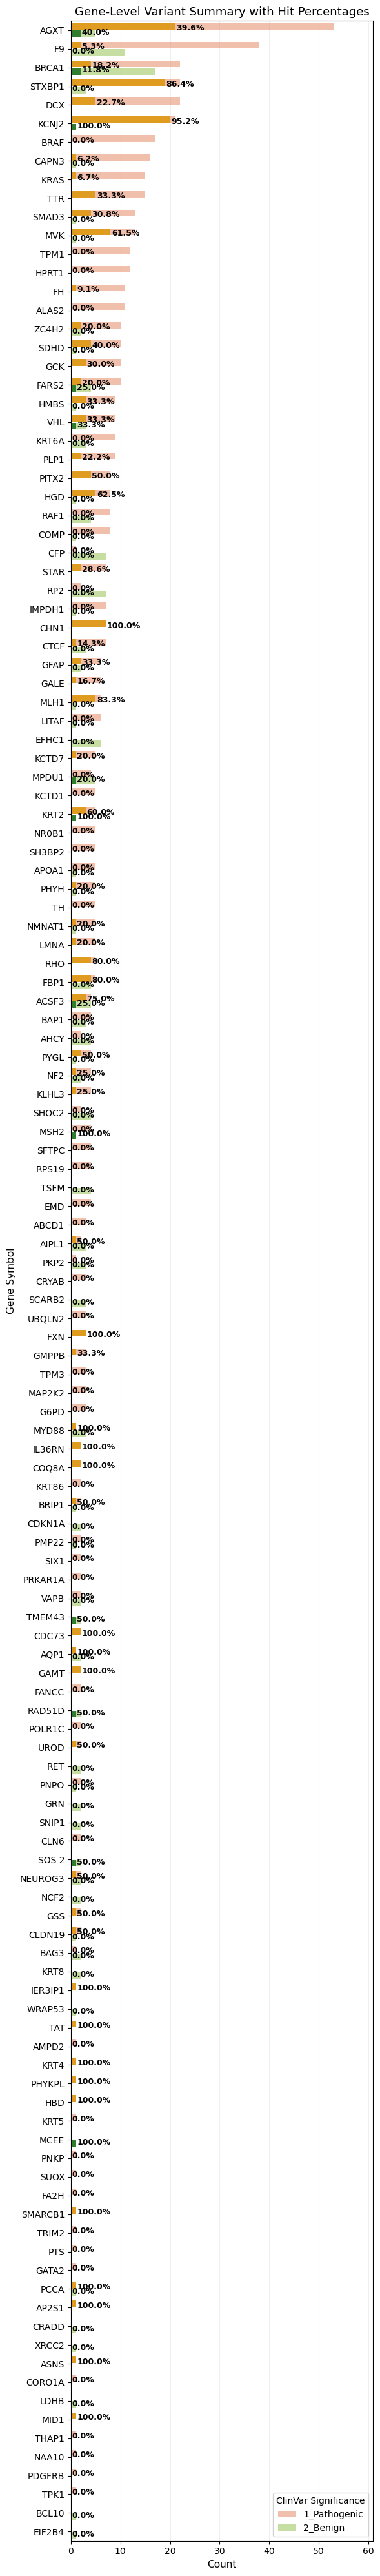

,symbol,clinvar_clnsig_clean,total_counts,hit_counts,hit_perc
0,AGXT,1_Pathogenic,53,21,39.622642
1,F9,1_Pathogenic,38,2,5.263158
2,BRCA1,1_Pathogenic,22,4,18.181818
3,STXBP1,1_Pathogenic,22,19,86.363636
4,DCX,1_Pathogenic,22,5,22.727273
...,...,...,...,...,...
179,LITAF,2_Benign,1,0,0.000000
180,BCL10,2_Benign,1,0,0.000000
181,IMPDH1,2_Benign,1,0,0.000000
182,EIF2B4,2_Benign,1,0,0.000000


In [273]:
# fig, ax = plt.subplots(1,1,figsize=(7,15))
plot_gene_level_summary(img_dual_ppi_by_gene_cv_hits)

In [300]:
img_dual_ppi_df_scores = img_dual_ppi_df.with_columns(
    pl.when(pl.col("clinvar_clnsig_clean")=="1_Pathogenic")
    .then(pl.lit(1))
    .when(pl.col("clinvar_clnsig_clean")=="2_Benign")
    .then(pl.lit(0))
    .otherwise(None)
    .alias("1_Pathogenic"),
    pl.col("abund_zscore").neg().alias("abun_change_score")
).drop_nulls(
    pl.col("1_Pathogenic")
)

# img_dual_ppi_df["perturbed_percentage"].unique()

In [295]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
set2_palette = sns.color_palette("Set2")

def compute_aubprc(auprc, prior):
    return (auprc*(1-prior))/((auprc*(1-prior)) + ((1-auprc)*prior))


def plot_auroc_curves(df_clinvar_w_scores, pos_label, methods, set2_palette=set2_palette):
    """
    For each method, plot the adjusted PR curve (with both balanced and monotonized adjustments)
    and compute the adjusted AUPRC via bootstrapping. Also perform pairwise significance testing 
    of the AUPRC across different RSA categories.
    
    Parameters
    ----------
    df_clinvar_w_scores : Polars DataFrame
        Input data including columns "clinvar_clnsig_clean", category and predictor scores.
    methods : list of str
        List of method names corresponding to score columns in the data.
    set2_palette : list of str
        List of colors (e.g., from a color palette) to use for different RSA categories.
    n_bootstrap : int, optional
        Number of bootstrap iterations for significance testing (default is 1000).
    random_state : int or None, optional
        Seed for reproducibility.
    
    Returns
    -------
    ap_results : dict
        Dictionary of adjusted AUPRC values and bootstrap distributions, structured as:
          { method: { category: {"AP": <adjusted AUPRC>, "boot_ap": <bootstrap array> } } }
    significance : dict
        Dictionary mapping each method to a DataFrame of pairwise p-values comparing AUPRC between categories.
    """
    fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        
    ap_results = {}  # to store adjusted AUPRC and bootstrap distributions
    # significance = {}  # to store pairwise significance p-values per method
    
    for m_idx, met in enumerate(methods):
        ap_results[met] = {}
        # Filter data for current category and valid clinical labels.
        df_clin_per_method = df_clinvar_w_scores.filter(
            (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]))
        ).with_columns(
            (
                pl.when(pl.col("clinvar_clnsig_clean") == pos_label)
                .then(1)
                .otherwise(0)
            ).alias("clinvar_label")
        ).drop_nulls(subset=["clinvar_clnsig_clean", met])
        
        # Convert to pandas DataFrame.
        df_pd = df_clin_per_method.to_pandas()
        df_pd = df_pd[["clinvar_label", met]].dropna()
        # Convert clinvar_label to boolean.
        truth = df_pd["clinvar_label"].astype(bool)
        # Create a scores DataFrame (with one column).
        scores = df_pd[[met]]
        # Create the YogiROC2 object using the new YogiROC2() constructor.
        fpr, tpr, thresholds = roc_curve(truth, scores)
        # Get the performance table from the YogiROC2 object.
        auc_score = roc_auc_score(truth, scores)
        ap_results[met] = auc_score

        # Plot the adjusted PR curve.
        axes.plot(100 * fpr, 100 * tpr,
                label=f"{met}: {auc_score:.2f}",
                color=set2_palette[methods.index(met)])
        # Plot chance level as a horizontal dashed line.
        # axes[m_idx].axhline(y=100 * prior, color=set2_palette[plddt_cats.index(cat)], ls="--")
    # Customize the subplot.
    handles, labels = axes.get_legend_handles_labels()
    # order = [2,1,0] if "rsa" in category else [3,1,0,2]
    precision_label = "True Positive Rate (%)"
    # title = f"AUROC by {category}"
    
    axes.legend(loc="lower right",
                    title="Assay")
    axes.set_xlabel("False Positive Rate (%)")
    axes.set_ylabel(precision_label)
    # axes[m_idx].set_title(met.split("_")[0])
    axes.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    # plt.subplots_adjust(wspace=0.04)
    
    return ap_results ## , sig_results_dict

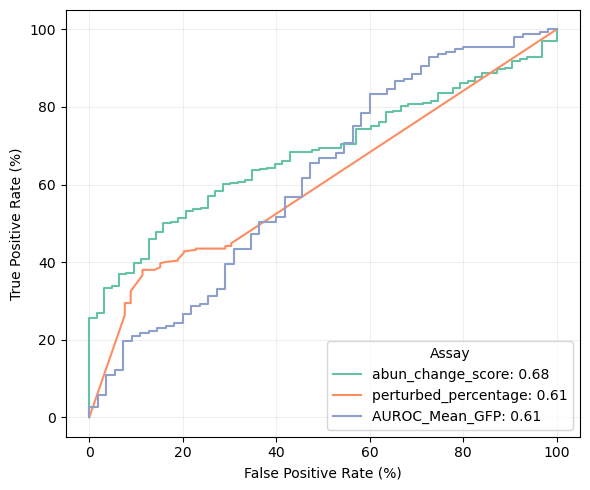

In [296]:
ap_results_dict = plot_auroc_curves(img_dual_ppi_df_scores, "1_Pathogenic", 
                                    methods=["abun_change_score", "perturbed_percentage", "AUROC_Mean_GFP"])

{'abun_change_score': {'AUPRC': np.float64(0.7514950280292664)},
 'ppi_pert_perc': {'AUPRC': np.float64(0.37519594860661115)},
 'AUROC_Mean_GFP': {'AUPRC': np.float64(0.6198348625712236)}}

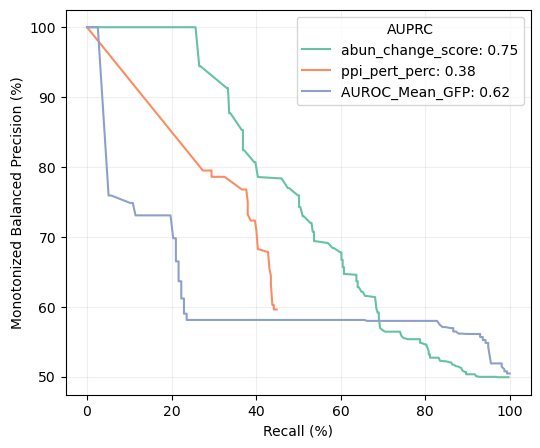

In [298]:
def plot_adjusted_pr_curves(df_clinvar_w_scores, pos_label, methods, monotonized_flag, balanced_flag, subsample=False, set2_palette=set2_palette, n_bootstrap=1000, random_state=None):
    """
    For each method, plot the adjusted PR curve (with both balanced and monotonized adjustments)
    and compute the adjusted AUPRC via bootstrapping. Also perform pairwise significance testing 
    of the AUPRC across different RSA categories.
    
    Parameters
    ----------
    df_clinvar_w_scores : Polars DataFrame
        Input data including columns "clinvar_clnsig_clean", category and predictor scores.
    methods : list of str
        List of method names corresponding to score columns in the data.
    set2_palette : list of str
        List of colors (e.g., from a color palette) to use for different RSA categories.
    n_bootstrap : int, optional
        Number of bootstrap iterations for significance testing (default is 1000).
    random_state : int or None, optional
        Seed for reproducibility.
    
    Returns
    -------
    ap_results : dict
        Dictionary of adjusted AUPRC values and bootstrap distributions, structured as:
          { method: { category: {"AP": <adjusted AUPRC>, "boot_ap": <bootstrap array> } } }
    significance : dict
        Dictionary mapping each method to a DataFrame of pairwise p-values comparing AUPRC between categories.
    """
    assert (balanced_flag and not subsample) or (subsample and not balanced_flag) or (not subsample and not balanced_flag)
    
    ap_results_dict = {}
    fig, axes = plt.subplots(1, 1, figsize=(6, 5))
    if len(methods) == 1:
        axes = [axes]
        
    ap_results = {}  # to store adjusted AUPRC and bootstrap distributions
    # significance = {}  # to store pairwise significance p-values per method
    
    for m_idx, met in enumerate(methods):
        ap_results[met] = {}
        
        # Filter data for current category and valid clinical labels.
        df_clin_per_method = df_clinvar_w_scores.filter(
            (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]))
        ).with_columns(
            pl.col(pos_label).alias("clinvar_label"),
            pl.col(met).cast(pl.Float64).alias(met)
        ).drop_nulls(subset=["clinvar_clnsig_clean", met])
        
        # Convert to pandas DataFrame.
        df_pd = df_clin_per_method.to_pandas()
        if subsample:
            # Assume df is your existing DataFrame with a column named "label"
            # Find the minimum count among the two classes (0 and 1)
            min_count = df_pd['clinvar_label'].value_counts().min()
            # Group by the 'label' column and sample min_count rows from each group (without replacement)
            df_pd = df_pd.groupby('clinvar_label').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

        # Convert clinvar_label to boolean.
        truth = df_pd["clinvar_label"].astype(bool)
        # Create a scores DataFrame (with one column).
        scores = df_pd[[met]]

        # Create the YogiROC2 object using the new YogiROC2() constructor.
        yrobj = YogiROC2(truth, scores, names=[met], high=True)
        # Get the performance table from the YogiROC2 object.
        table = yrobj.tables[met]

        if (monotonized_flag and balanced_flag):
            table = table.dropna()
            
        precision = configure_prec(table, monotonized_flag=monotonized_flag, balanced_flag=balanced_flag)
        recall = table["tpr_sens"].values
        ap = calc_auc(recall[~np.isnan(recall)], precision[~np.isnan(precision)])
        ap_results[met] = {"AUPRC": ap}

        # Plot the adjusted PR curve.
        axes.plot(100 * recall, 100 * precision,
                  label=f"{met}: {ap:.2f}",
                  color=set2_palette[methods.index(met)])
        # Plot chance level as a horizontal dashed line.
        prior = np.sum(truth) / df_pd.shape[0]
        if (not balanced_flag):
            axes.axhline(y=100 * prior, color=set2_palette[-1], ls="--")
        precision_label = "Precision (%)"
        title = f"AUPRC"
        if balanced_flag:
            precision_label = "Balanced " + precision_label
            # title = "Balanced " + title
        if monotonized_flag:
            precision_label = "Monotonized " + precision_label
            # title = "Balanced " + title

    # Customize the subplot.
    # handles, labels = axes[methods.index(met)].get_legend_handles_labels()
    axes.legend(loc="upper right", title=title)
    axes.set_xlabel("Recall (%)")
    axes.set_ylabel(precision_label)
    # axes.set_title(met.split("_")[0])
    axes.grid(alpha=.2)
    
    ap_results_dict = ap_results
    # # sig_results_dict[category] = significance
    # plt.tight_layout()
    # plt.show()
    # # plt.subplots_adjust(wspace=0.04)
    return ap_results_dict ## , sig_results_dict

plot_adjusted_pr_curves(
    img_dual_ppi_df_scores.with_columns(
        (pl.col("perturbed_percentage") / 100).alias("ppi_pert_perc")
    ), 
    pos_label="1_Pathogenic", 
    methods=["abun_change_score", "ppi_pert_perc", "AUROC_Mean_GFP"], 
    monotonized_flag=True, balanced_flag=True)

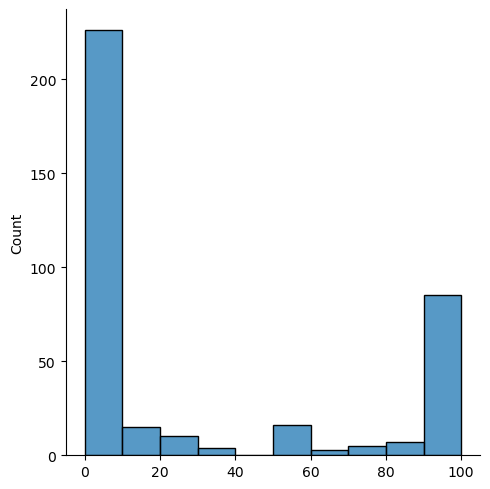

In [299]:
sns.displot(img_dual_ppi_df_scores["perturbed_percentage"])